## Assignment 2 – Rent the Runway Analysis Project  
Alina Markova, Jesse Miller, Leia Kawamura, Sophia Salas  
CSE 158, 258 / MGTA 461  


**Goal:** Use the Rent the Runway-style dataset to build several recommender-style prediction tasks.

We focus on three predictive tasks:

1. **Task 1 – Rating Prediction: user/item AND sentiment**: predict whether a review is generally positive / neutral / negative from text and predict a reviewers rating.
2. **Task 2 – Category/Event prediction**: predict what the item was rented for (e.g., wedding, work, vacation) based on review text.
3. **Task 3 – Fit prediction**: predict whether the clothing item ran *small / fit / large* based on user body measurements and item metadata.

Each task includes:
- Task definition & motivation
- Baseline model
- A simple but stronger model (mostly logistic regression)
- Evaluation and brief discussion

## Data

Steps prior to analysis:

- Ensure column names are consistent.
- Convert numeric fields (height, weight, age, rating, size).
- Parse the target labels for each predictive task.



In [6]:
import pandas as pd
import numpy as np
import random
import gzip
import json
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC

from collections import Counter
from collections import defaultdict
import re

In [7]:
# TODO: CHANGE THIS PATH to your actual file before
data_path = "renttherunway_final_data.json.gz"

df = pd.read_json(data_path, compression="gzip", lines=True)

print("Data shape:", df.shape)
df.head()

Data shape: (192544, 15)


,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28.0,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36.0,"June 18, 2013"
2,fit,360448,NaN,1063761,NaN,10.0,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116.0,"December 14, 2015"
3,fit,909926,34c,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34.0,"February 12, 2014"
4,fit,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27.0,"September 26, 2016"


## Exploratory Analysis & Basic Cleaning

Here we:

- Look at distributions of `rating`, `fit`, and `rented for`.
- Check a few example reviews.
- Clean numeric columns (height, weight, age, size).
- Create helper numeric columns that will be used in Task 3 (fit prediction).

This gives us intuition about class balance and data quality, and will help us
define sensible baselines (e.g., majority-class predictors).

In [8]:
df["rating"].describe()

count    192462.000000
mean          9.092371
std           1.430044
min           2.000000
25%           8.000000
50%          10.000000
75%          10.000000
max          10.000000
Name: rating, dtype: float64

In [9]:
df["fit"].value_counts(dropna=False).head(20)

fit
fit      142058
small     25779
large     24707
Name: count, dtype: int64

In [10]:
df["rented for"].value_counts(dropna=False).head(20)

rented for
wedding            57784
formal affair      40408
party              35626
everyday           16822
other              15388
work               15042
date                7388
vacation            4075
NaN                   10
party: cocktail        1
Name: count, dtype: int64

In [11]:
df[["review_text", "rating", "fit", "rented for"]].sample(5, random_state=0)

,review_text,rating,fit,rented for
75824,I rented this dress for a bachelorette trip to...,8.0,fit,vacation
131798,I wore this for a date night with my husband. ...,6.0,fit,everyday
93869,This was my first experience with Rent the Run...,10.0,fit,wedding
175761,This dress really stands out because it's uniq...,8.0,fit,party
15568,I thought it ran on the larger side but that s...,4.0,large,everyday


<Axes: xlabel='rating', ylabel='Count'>

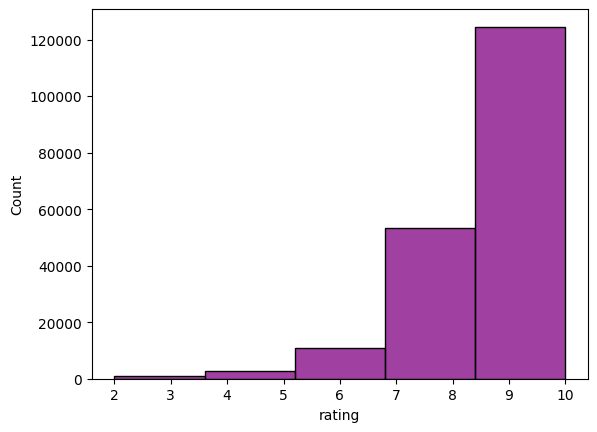

In [12]:
sns.histplot(df["rating"], bins=5, color="purple")

### Numeric cleanup

Some fields come in as strings, e.g. height `"5' 8\""` or weight `"137lbs"`.
Below we implement simple parsers to convert them into numeric features.

These don't need to be perfect, just consistent:

- Height → inches
- Weight → pounds (numeric)
- Size, age, rating → numeric


In [13]:
def parse_height(s):
    """Convert height like 5' 8" into total inches. Return NaN if fails."""
    if pd.isna(s):
        return np.nan
    m = re.findall(r"(\d+)", str(s))
    if len(m) >= 2:
        feet = int(m[0])
        inches = int(m[1])
        return feet * 12 + inches
    elif len(m) == 1:
        # Just inches
        return float(m[0])
    return np.nan


def parse_weight(s):
    if pd.isna(s):
        return np.nan
    m = re.findall(r"(\d+)", str(s))
    if m:
        return float(m[0])
    return np.nan


for col in ["size", "age", "rating"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df["height_in"] = df["height"].apply(parse_height)
df["weight_lbs"] = df["weight"].apply(parse_weight)

df[["height", "height_in", "weight", "weight_lbs", "size", "age"]].head()

,height,height_in,weight,weight_lbs,size,age
0,"5' 8""",68.0,137lbs,137.0,14,28.0
1,"5' 6""",66.0,132lbs,132.0,12,36.0
2,"5' 4""",64.0,NaN,NaN,4,116.0
3,"5' 5""",65.0,135lbs,135.0,8,34.0
4,"5' 9""",69.0,145lbs,145.0,12,27.0


After this step, we have numeric versions of height and weight, as well as
numeric ratings, sizes, and ages. We’ll still keep the raw strings around in
case we want to inspect them, but the models will mainly use the numeric
versions.

---
### Task 1 – Rating Prediction (A) / Rating Sentiment Prediction (B)

**Goal:** Use the two subtasks to show feature types of text features (TF-IDF) and user-item IDs (biases). We are capturing both textual sentiment and user-item rating behavior, giving a full picture review of the dynamics of the ratings and our predictions. This allows us to compare the models that use text versus the models that use use/item interactions.

**Why Both?:** Using both text-based sentiment classification and user–item rating prediction allows us to model the dataset from two complementary angles: what users **say** in their reviews and how they **behave** through their ratings. The two subtasks highlight different ML methods (NLP vs. collaborative filtering) and give a more complete analysis of the data.

---
#### Subtask A: User-Item Rating Prediction (Regression) (predict a reviewer’s exact numeric rating)

**Goal:** Given a *user* and an *item*, predict the exact numeric rating the user would give (on a 1–10 scale).  
This models personalized preferences purely from historical rating behavior.

**Inputs:** `user_id` `item_id`  
**Output:** a continuous rating prediction (regression)  
**Metrics:** Mean Squared Error (MSE), Regularized objective  

Here, we use a bias-based collaborative filtering model, where the predicted rating is decomposed into:
* global average rating (α)
* user bias (βᵤ)
* item bias (βᵢ)
  
This is a classic and interpretable recommender system baseline.
We evaluate different regularization strengths (λ) and measure both training and validation MSE to select the best model.


In [14]:
# load
def read_rtr(path):
    with gzip.open(path, "rt") as f:
        for line in f:
            yield json.loads(line)


DATA_PATH = "renttherunway_final_data.json.gz"

data = list(read_rtr(DATA_PATH))
print("Total records:", len(data))

# train/validation split
indices = list(range(len(data)))
random.shuffle(indices)
split = int(0.8 * len(indices))
train_idx = set(indices[:split])
valid_idx = set(indices[split:])

train_data = [data[i] for i in train_idx]
valid_data = [data[i] for i in valid_idx]

print("Train size:", len(train_data))
print("Valid size:", len(valid_data))


Total records: 192544
Train size: 154035
Valid size: 38509


In [15]:
# r ≈ alpha + beta_u + beta_i  (user/item bias model)

# Helper
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom > 0:
        return numer / denom
    return 0.0


# extract ratings from dataset and build rating triples (u, i, r) from data
def extract_ratings(dataset):
    ratings = []
    for d in dataset:
        if "rating" in d and d["rating"] not in (None, "", "nan"):
            try:
                r = float(d["rating"])
            except ValueError:
                continue
            u = d["user_id"]
            i = d["item_id"]
            ratings.append((u, i, r))
    return ratings


ratingsTrain = extract_ratings(train_data)
ratingsValid = extract_ratings(valid_data)

print("Train ratings:", len(ratingsTrain))
print("Valid ratings:", len(ratingsValid))

# Build per-user / per-item maps
ratingsPerUser = defaultdict(list)
ratingsPerItem = defaultdict(list)
for u, b, r in ratingsTrain:
    ratingsPerUser[u].append((b, r))
    ratingsPerItem[b].append((u, r))

Train ratings: 153969
Valid ratings: 38493


In [16]:
# getting the global average rating
def getGlobalAverage(trainRatings):
    return sum(r for (_, _, r) in trainRatings) / len(trainRatings)


# Bias Model Updates
# improving alpha update with regularization
def alphaUpdate(ratingsTrain, alpha, betaU, betaI, lamb):
    newAlpha = 0.0
    for u, b, r in ratingsTrain:
        newAlpha += r - (betaU.get(u, 0.0) + betaI.get(b, 0.0))
    return newAlpha / (len(ratingsTrain) + lamb)


def betaUUpdate(ratingsPerUser, alpha, betaU, betaI, lamb):
    newBetaU = {}
    for u in ratingsPerUser:
        num = 0.0
        for b, r in ratingsPerUser[u]:
            num += r - (alpha + betaI.get(b, 0.0))
        newBetaU[u] = num / (lamb + len(ratingsPerUser[u]))
    return newBetaU


def betaIUpdate(ratingsPerItem, alpha, betaU, betaI, lamb):
    newBetaI = {}
    for b in ratingsPerItem:
        num = 0.0
        for u, r in ratingsPerItem[b]:
            num += r - (alpha + betaU.get(u, 0.0))
        newBetaI[b] = num / (lamb + len(ratingsPerItem[b]))
    return newBetaI


# MSE Computation
def msePlusReg(ratingsTrain, alpha, betaU, betaI, lamb):
    mse = 0.0
    for u, b, r in ratingsTrain:
        pred = alpha + betaU.get(u, 0.0) + betaI.get(b, 0.0)
        mse += (r - pred) ** 2
    mse /= len(ratingsTrain)

    # regularization penalty
    reg = sum(b**2 for b in betaU.values()) + sum(b**2 for b in betaI.values())
    return mse, mse + lamb * reg


def validMSE(ratingsValid, alpha, betaU, betaI):
    mse = 0.0
    for u, b, r in ratingsValid:
        pred = alpha + betaU.get(u, 0.0) + betaI.get(b, 0.0)
        mse += (r - pred) ** 2
    mse /= len(ratingsValid)
    return mse


# Training Loop
def train_bias_model(ratingsTrain, ratingsPerUser, ratingsPerItem, lamb=1.0, iters=30):
    alpha = getGlobalAverage(ratingsTrain)
    betaU = defaultdict(float)
    betaI = defaultdict(float)

    for _ in range(iters):
        alpha = alphaUpdate(ratingsTrain, alpha, betaU, betaI, lamb)

        newBetaU = betaUUpdate(ratingsPerUser, alpha, betaU, betaI, lamb)
        newBetaI = betaIUpdate(ratingsPerItem, alpha, betaU, betaI, lamb)

        betaU.update(newBetaU)  # refine existing estimates, not reset
        betaI.update(newBetaI)
    return alpha, betaU, betaI

In [17]:
# Hyperparameter search for best lambda
# lambda:
for lamb in [8, 8.3, 8.4, 8.5]:  # previously tried .1 through 10
    alpha_tmp, bu_tmp, bi_tmp = train_bias_model(
        ratingsTrain, ratingsPerUser, ratingsPerItem, lamb=lamb, iters=30
    )
    print(
        f"λ={lamb}  Valid MSE={validMSE(ratingsValid, alpha_tmp, bu_tmp, bi_tmp):.4f}"
    )

# Lambda (manual) after results
best_lambda = 8.4

alpha, betaU, betaI = train_bias_model(
    ratingsTrain, ratingsPerUser, ratingsPerItem, lamb=best_lambda, iters=30
)

# final metrics
train_mse, train_obj = msePlusReg(ratingsTrain, alpha, betaU, betaI, lamb=best_lambda)
valid_mse = validMSE(ratingsValid, alpha, betaU, betaI)

print("Rating prediction:")
print("  Train MSE:", train_mse)
print("  Valid MSE:", valid_mse)

λ=8  Valid MSE=1.8831
λ=8.3  Valid MSE=1.8830
λ=8.4  Valid MSE=1.8829
λ=8.5  Valid MSE=1.8829
Rating prediction:
  Train MSE: 1.5249684727349941
  Valid MSE: 1.8829389394316112


---
#### Subtask B: Rating Sentiment Prediction (whether a review can be classified as positive, negative, or neutral)

**Goal:** Given the review text, predict whether the reviewer gave a:
* *Negative*: rating 1–6
* *Neutral* : 7–8
* *Positive*: 9–10

This turns a 1–10 rating scale into an easier, more interpretable sentiment label.

**Inputs:** `review_text`  
**Output:** 3-class label {0,1,2}  
**Metrics:**  
* Overall accuracy
* Per-class precision, recall, and F1 scores
  
Here, we use Text-Based Rating Sentiment Classification (NLP) to show text processing, feature engineering (TF-IDF, n-grams), and using a classifier to classify a review's sentiment from text alone.

We start with a majority-class baseline, then train a TF–IDF + logistic regression model.


In [18]:
def bucket_rating(r):
    if pd.isna(r):
        return np.nan
    if r <= 6:
        return 0  # negative
    elif r < 8.5:
        return 1  # neutral
    else:
        return 2  # positive


df["rating_bucket"] = df["rating"].apply(bucket_rating)

# Drop rows with missing text or rating bucket
task1_df = df.dropna(subset=["review_text", "rating_bucket"]).copy()

task1_df["rating_bucket"].value_counts(normalize=True)

rating_bucket
2.0    0.647073
1.0    0.277411
0.0    0.075516
Name: proportion, dtype: float64

In [19]:
X_text = task1_df["review_text"]
y_rating = task1_df["rating_bucket"]

X_train_text, X_test_text, y_train_rating, y_test_rating = train_test_split(
    X_text, y_rating, test_size=0.2, random_state=42, stratify=y_rating
)

len(X_train_text), len(X_test_text)

(153969, 38493)

#### Baseline – Majority class

As a baseline, we predict the most frequent class in the training set
for every example. This gives us a lower bound on performance: any useful
model should beat this.

In [20]:
majority_class = Counter(y_train_rating).most_common(1)[0][0]

y_pred_majority = np.full_like(y_test_rating, fill_value=majority_class)

baseline_acc = accuracy_score(y_test_rating, y_pred_majority)
print("Majority baseline accuracy:", baseline_acc)
print("Majority class:", majority_class)

Majority baseline accuracy: 0.6470786896318811
Majority class: 2.0


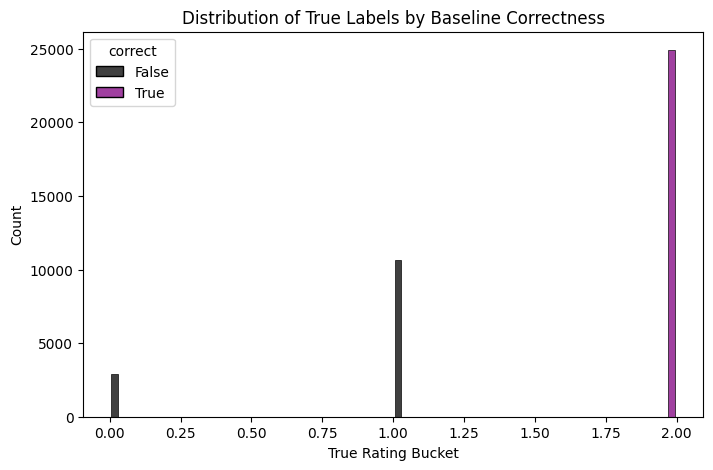

In [21]:
baseline_df = pd.DataFrame(
    {
        "true_label": y_test_rating.values,
        "pred_label": y_pred_majority,
    }
)

baseline_df["correct"] = baseline_df["true_label"] == baseline_df["pred_label"]
baseline_df["index"] = baseline_df.index  # for x-axis

plt.figure(figsize=(8, 5))
sns.histplot(
    data=baseline_df,
    x="true_label",
    hue="correct",
    multiple="dodge",
    palette={True: "purple", False: "black"},
    shrink=0.8,
)

plt.title("Distribution of True Labels by Baseline Correctness")
plt.xlabel("True Rating Bucket")
plt.ylabel("Count")
plt.show()

#### Model – TF–IDF + Logistic Regression

For our first “real” model, we:

- Convert reviews into TF–IDF vectors (bag-of-words with unigrams and bigrams).
- Train a multinomial logistic regression classifier.

This matches the text classification material from class and gives us an
interpretable linear model where we can later inspect which words drive
positive vs. negative predictions.


In [22]:
tfidf_rating = TfidfVectorizer(max_features=20000, ngram_range=(1, 2), min_df=5)

log_reg_rating = LogisticRegression(max_iter=1000, multi_class="multinomial", n_jobs=-1)

rating_clf = Pipeline([("tfidf", tfidf_rating), ("clf", log_reg_rating)])

rating_clf.fit(X_train_text, y_train_rating)

y_pred_rating = rating_clf.predict(X_test_text)

acc_rating = accuracy_score(y_test_rating, y_pred_rating)
print("TF–IDF + Logistic Regression accuracy:", acc_rating)

print("\nClassification report:")
print(classification_report(y_test_rating, y_pred_rating, digits=3))

/opt/base-uv/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


TF–IDF + Logistic Regression accuracy: 0.7355363312810121

Classification report:
              precision    recall  f1-score   support

         0.0      0.686     0.469     0.557      2907
         1.0      0.564     0.431     0.489     10678
         2.0      0.788     0.897     0.839     24908

    accuracy                          0.736     38493
   macro avg      0.679     0.599     0.628     38493
weighted avg      0.718     0.736     0.721     38493



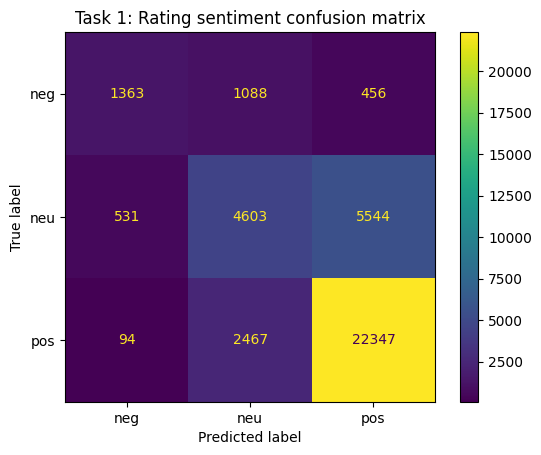

In [23]:
cm_rating = confusion_matrix(y_test_rating, y_pred_rating)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_rating, display_labels=["neg", "neu", "pos"]
)
disp.plot()
plt.title("Task 1: Rating sentiment confusion matrix")
plt.show()

---
### Task 2 – Category / Event Prediction (text → `rented for`)

**Goal:** Given the review text, predict what the item was rented for
(e.g., wedding, work, vacation).

This is again a text classification problem, but the classes correspond to
different *use cases* or *events* instead of sentiment (multi-class classification)

**Inputs:** `review_text`  
**Output:** multiple classes (values of `rented for`)  
**Metrics:** accuracy + per-class precision/recall/F1.

To keep the problem manageable, we optionally restrict to the top-k most common
`rented for` values and drop the tail of very rare labels.


In [24]:
# Choose the top K most frequent 'rented for' values
K = 5
top_events = df["rented for"].value_counts().nlargest(K).index.tolist()
print("Top events:", top_events)

task2_df = (
    df[df["rented for"].isin(top_events)]
    .dropna(subset=["review_text", "rented for"])
    .copy()
)

task2_df["rented for"].value_counts(normalize=True)

Top events: ['wedding', 'formal affair', 'party', 'everyday', 'other']


rented for
wedding          0.348038
formal affair    0.243381
party            0.214578
everyday         0.101320
other            0.092683
Name: proportion, dtype: float64

In [25]:
X_event_text = task2_df["review_text"]
y_event = task2_df["rented for"]

X_train_event, X_test_event, y_train_event, y_test_event = train_test_split(
    X_event_text, y_event, test_size=0.2, random_state=42, stratify=y_event
)

len(X_train_event), len(X_test_event)

(132822, 33206)

###  Baseline – Majority event

We again start with a simple baseline that always predicts the most common
`rented for` value in the training set.

In [26]:
majority_event = Counter(y_train_event).most_common(1)[0][0]

y_pred_event_majority = np.array([majority_event] * len(y_test_event))

baseline_event_acc = accuracy_score(y_test_event, y_pred_event_majority)
print("Majority-event baseline accuracy:", baseline_event_acc)
print("Majority event label:", majority_event)

Majority-event baseline accuracy: 0.34803951093175933
Majority event label: wedding


### Model – TF–IDF + Logistic Regression for Event Prediction

We reuse almost the same pipeline as in Task 1, but this time the labels are
the `rented for` categories.

This will let us later analyze which words are associated with weddings,
vacations, professional events, etc.


In [27]:
tfidf_event = TfidfVectorizer(
    stop_words="english",
    max_features=15000,  # smaller, reduces overfitting
    ngram_range=(1, 2),  # bigrams only (trigrams caused sparsity)
    min_df=2,  # removes noisy single-use phrases
)

log_reg_event = LogisticRegression(
    max_iter=2000,
    multi_class="multinomial",
    class_weight="balanced",
    n_jobs=-1,
    C=2.0,  # slightly larger to reduce underfitting
)

event_clf = Pipeline([("tfidf", tfidf_event), ("clf", log_reg_event)])


event_clf.fit(X_train_event, y_train_event)
y_pred_event = event_clf.predict(X_test_event)

acc_event = accuracy_score(y_test_event, y_pred_event)
print("Event prediction accuracy:", acc_event)

print("\nClassification report:")
print(classification_report(y_test_event, y_pred_event, digits=3))

/opt/base-uv/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Event prediction accuracy: 0.5347828705655604

Classification report:
               precision    recall  f1-score   support

     everyday      0.531     0.743     0.619      3364
formal affair      0.539     0.570     0.554      8082
        other      0.259     0.373     0.305      3078
        party      0.487     0.434     0.459      7125
      wedding      0.700     0.555     0.619     11557

     accuracy                          0.535     33206
    macro avg      0.503     0.535     0.511     33206
 weighted avg      0.557     0.535     0.540     33206



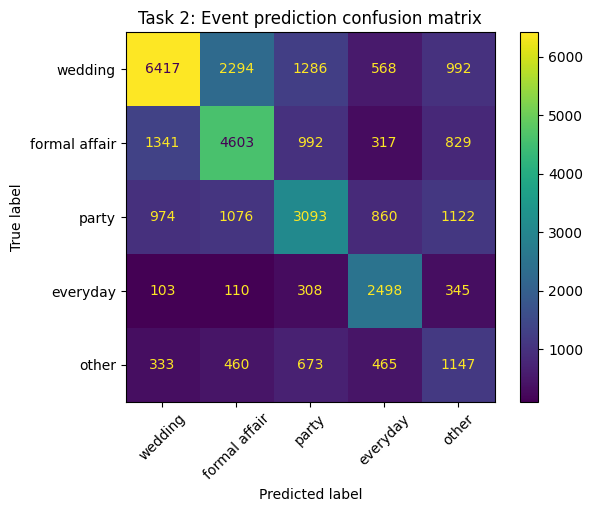

In [28]:
cm_event = confusion_matrix(y_test_event, y_pred_event, labels=top_events)
disp_event = ConfusionMatrixDisplay(
    confusion_matrix=cm_event, display_labels=top_events
)
disp_event.plot(xticks_rotation=45)
plt.title("Task 2: Event prediction confusion matrix")
plt.show()

---
### Task 3 – Fit Prediction (measurements → small / fit / large)

**Goal:** Predict whether the reported fit is:

- `"small"`
- `"fit"`
- `"large"`

based on user and item information.

This is directly related to a size recommendation tool: if we can accurately
predict when a given size will run small or large for a user, we could suggest
sizing up or down. We use structured numeric inputs here to predict fit (reducing long term returns)

**Inputs (features):**

- Numeric: `height_in`, `weight_lbs`, `size`, `age`, `rating`
- Categorical: `body type`, `category`, `rented for`

**Output:** 3-class label (`fit`).  
**Metrics:** accuracy + per-class precision/recall/F1.

We, again, compare a majority-class baseline to a logistic regression model that
uses both numeric and one-hot-encoded categorical features.


In [29]:
required_cols = [
    "fit",
    "height_in",
    "weight_lbs",
    "size",
    "age",
    "body type",
    "category",
    "rented for",
]

task3_df = df.dropna(subset=required_cols).copy()

# Keep only the three main fit labels (in case there are others)
mask_fit = task3_df["fit"].isin(["small", "fit", "large"])
task3_df = task3_df[mask_fit].copy()

task3_df["fit"].value_counts(normalize=True)

fit
fit      0.736073
small    0.134001
large    0.129926
Name: proportion, dtype: float64

In [30]:
feature_cols_numeric = ["height_in", "weight_lbs", "size", "rating"]
feature_cols_cat = ["body type", "category", "rented for"]

X_fit = task3_df[feature_cols_numeric + feature_cols_cat]
y_fit = task3_df["fit"]

X_train_fit, X_test_fit, y_train_fit, y_test_fit = train_test_split(
    X_fit, y_fit, test_size=0.2, random_state=42, stratify=y_fit
)

len(X_train_fit), len(X_test_fit)

(122524, 30632)

### Baseline – Majority fit label

We start with a trivial baseline: predict the most common fit label for every example.


In [31]:
majority_fit = Counter(y_train_fit).most_common(1)[0][0]
y_pred_fit_majority = np.full_like(y_test_fit, majority_fit)

baseline_fit_acc = accuracy_score(y_test_fit, y_pred_fit_majority)
print("Fit majority baseline accuracy:", baseline_fit_acc)
print("Majority fit label:", majority_fit)

Fit majority baseline accuracy: 0.7360603290676416
Majority fit label: fit


### Model – Numeric + Categorical Features via Logistic Regression

We build a feature pipeline:

- Numeric features are standardized (zero mean, unit variance).
- Categorical features are one-hot encoded.
- A multinomial logistic regression is trained on the combined feature space.

This model uses both user measurements and item metadata to predict fit.


In [32]:
feature_cols_numeric = ["height_in", "weight_lbs", "size", "age", "rating"]
feature_cols_cat = ["body type", "category", "rented for"]

print("NaNs per column:")
print(df[feature_cols_numeric + feature_cols_cat + ["fit"]].isna().sum())


NaNs per column:
height_in       677
weight_lbs    29982
size              0
age             960
rating           82
body type     14637
category          0
rented for       10
fit               0
dtype: int64


In [33]:
feature_cols_numeric = ["height_in", "weight_lbs", "size", "age", "rating"]
feature_cols_cat = ["body type", "category", "rented for"]

required_cols = ["fit"] + feature_cols_numeric + feature_cols_cat

# Keep only rows that have *all* required columns present
task3_df = df[required_cols].dropna().copy()

# Keep only the three main fit labels
mask_fit = task3_df["fit"].isin(["small", "fit", "large"])
task3_df = task3_df[mask_fit].copy()

print("Remaining rows for Task 3:", len(task3_df))
print(task3_df.isna().sum())  # should all be 0


Remaining rows for Task 3: 153100
fit           0
height_in     0
weight_lbs    0
size          0
age           0
rating        0
body type     0
category      0
rented for    0
dtype: int64


In [34]:
# Split
X_fit = task3_df[feature_cols_numeric + feature_cols_cat]
y_fit = task3_df["fit"]

X_train_fit, X_test_fit, y_train_fit, y_test_fit = train_test_split(
    X_fit, y_fit, test_size=0.2, random_state=42, stratify=y_fit
)


In [35]:
numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])

categorical_transformer = Pipeline(
    steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))]
)

preprocess_fit = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, feature_cols_numeric),
        ("cat", categorical_transformer, feature_cols_cat),
    ]
)

fit_log_reg = LogisticRegression(max_iter=1000, multi_class="multinomial", n_jobs=-1)

fit_clf = Pipeline(steps=[("preprocess", preprocess_fit), ("clf", fit_log_reg)])

fit_clf.fit(X_train_fit, y_train_fit)

y_pred_fit = fit_clf.predict(X_test_fit)

acc_fit = accuracy_score(y_test_fit, y_pred_fit)
print("Fit model accuracy:", acc_fit)

print("\nFit classification report:")
print(classification_report(y_test_fit, y_pred_fit, digits=3))

/opt/base-uv/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fit model accuracy: 0.7377857609405617

Fit classification report:
              precision    recall  f1-score   support

         fit      0.748     0.984     0.850     22538
       large      0.444     0.041     0.076      3978
       small      0.401     0.059     0.104      4104

    accuracy                          0.738     30620
   macro avg      0.531     0.362     0.343     30620
weighted avg      0.662     0.738     0.650     30620



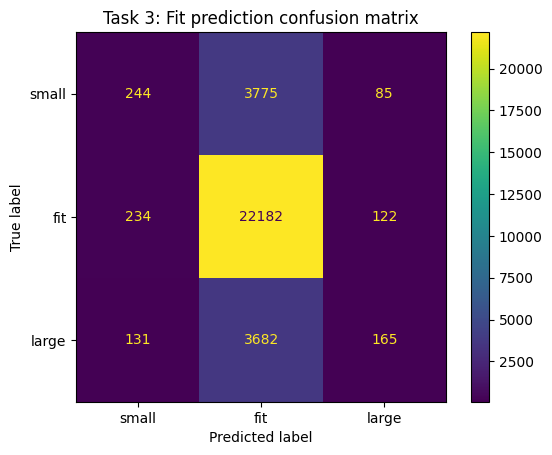

In [36]:
cm_fit = confusion_matrix(y_test_fit, y_pred_fit, labels=["small", "fit", "large"])
disp_fit = ConfusionMatrixDisplay(
    confusion_matrix=cm_fit, display_labels=["small", "fit", "large"]
)
disp_fit.plot()
plt.title("Task 3: Fit prediction confusion matrix")
plt.show()

---
## Overall Evaluation Summary

Here we put the key accuracy numbers side-by-side for the three tasks:

- **Task 1 – Rating sentiment**
  - Baseline accuracy: `baseline_acc`
  - Model accuracy: `acc_rating`

- **Task 2 – Event prediction**
  - Baseline accuracy: `baseline_event_acc`
  - Model accuracy: `acc_event`

- **Task 3 – Fit prediction**
  - Baseline accuracy: `baseline_fit_acc`
  - Model accuracy: `acc_fit`

We also create a simple bar chart comparing baselines and models across tasks:


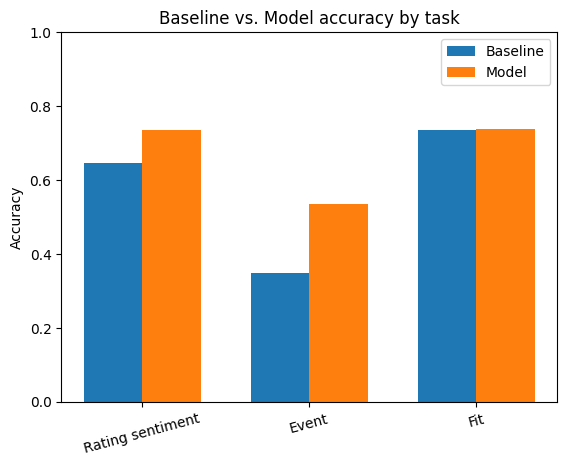

In [37]:
task_names = ["Rating sentiment", "Event", "Fit"]
baseline_scores = [baseline_acc, baseline_event_acc, baseline_fit_acc]
model_scores = [acc_rating, acc_event, acc_fit]

x = np.arange(len(task_names))
width = 0.35

plt.figure()
plt.bar(x - width / 2, baseline_scores, width, label="Baseline")
plt.bar(x + width / 2, model_scores, width, label="Model")
plt.xticks(x, task_names, rotation=15)
plt.ylabel("Accuracy")
plt.title("Baseline vs. Model accuracy by task")
plt.legend()
plt.ylim(0, 1.0)
plt.show()

## Outcome analysis:

Our models were able to predict, with considerable accuracy, the Rating and Event details. Fit, was not a category in which we could show drastic improvement. We infer that the root of this is that users select garments with high likelihood of fitting. An ill-fitting outfit would not be rented. This leads to a very strong baseline of ~73.6%. User measurements and available metadata do not provide enough signal to consistently predict the rare cases where items fit “small” or “large”.